## I) Retrieve datas

### What is wikidata :
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The problem with Wikipedia, when we want to retrieve structured information, is that the information is written in a block form that is easily readable for humans, but not for machines. If we take Emmanuel Macron's Wikipedia page as an example, the information is not displayed as a column (sex: male, nationality: French, function: president...). This does not seem to be noticeable, but it will be a problem when we want to retrieve, for example, the list of presidents of the fifth republic for example.

Fortunately, there is a tool that lists this information this way, Wikidata. Wikidata lists millions of named entities and concepts. For example, if we take Emmanuel Macron's page: https://www.wikidata.org/wiki/Q3052772, we have in a structured way, his city of birth, the names of his family members, his functions, the organizations of which he is a member, and a lot of other information.

In our use case, if we go to the page: https://www.wikidata.org/wiki/Q18001873, which is the Wikidata page of the first name "Emmanuel", we can see that we have the information instance of: male given name. This is the category that interests us. Now that we have this site, which is finally a bank of structured information, we are going to need a tool that will allow us to make queries to request all the pages that present the information "male given name".

### What is wikidata query?
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;To be able to retrieve this kind of information, it will be necessary to use a tool that belongs to Wikipedia: https://query.wikidata.org/. Thanks to the SPARQL language, we will be able to ask Wikidata to get us all the documents we are interested in. This language is similar to the SQL that we learned at EFREI in courses such as "Databases" studied in Semester 5 and 6 in which we learned how to manage a database using this language. This knowledge will be useful to roughly understand how to retrieve data using Wikidata Query. This is what a simple query on Wikidata query looks like.

### How to build the correct query

Here is the complete query, let's see how it's working: 
```SPARQL

SELECT ?city ?cityLabel ?population ?countryLabel ?coordinates ?countryCode
WHERE
{
  ?city wdt:P31/wdt:P279* wd:Q3257686.
  ?city wdt:P1082 ?population.
  OPTIONAL{?city wdt:P17 ?country.}
  OPTIONAL{?country wdt:P297 ?countryCode.}
  OPTIONAL {?city wdt:P625 ?coordinates .}
  FILTER (?population > 100000)
  
  SERVICE wikibase:label {
    bd:serviceParam wikibase:language "fr" .
  }
}
```

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; To meet my constraints, I had to retrieve all cities with more than 100,000 inhabitants as well as some of their attributes.  

#### Attributes
To build the query, we indicate the name of the attribute we want to give to our variable, then we indicate the attribbut identifier as it is filled in on the wikidata pages.
Here the line : 
```SPARQL
?city wdt:P31/wdt:P279* wd:Q3257686.
```
Will fetch, all wikidata pages containing the attribute `locality` (Q3257686) and give them the alias `city`.  


Then the line 
```SPARQL
?city wdt:P17 ?country.
```
Will be in charge of retrieving on each locality page, the associated country, and give it the "country" allias.

And so on for all the attributes.

#### Language selection
The next line permit to choose which language do you want for the output
```SPARQL
SERVICE wikibase:label { bd:serviceParam wikibase:language "fr" .}
```
Here all the results will be in `french` by changing "fr" to "en", you'll have the result in `english`

#### Some keywords
We will pay attention to several points: 
 * Add the keyword `FILTER` to respect our constraint.
 * Add the keyword `OPTIONAL`, in case one of the attribute is not in the wikidata page of one of the city, the query can return a result anyway




>You can run the query by yourself by following this link https://w.wiki/34$b

### Save the data

After processing this query, you can just download the datas as a csv file.  
Here, I saved the datas into 4 different files corresponding to their language

## II) Process Datas

We start with some simple preprocessing:
 * We remove the prefix of the wikidata link that doesn't interest us
 * We give Geographic coordinates a more conventional format.

In [24]:
import pandas as pd

In [25]:
raw_fr = pd.read_csv('Raw/GrandesVillesRaw_fr.csv')
raw_en = pd.read_csv('Raw/GrandesVillesRaw_en.csv')
raw_es = pd.read_csv('Raw/GrandesVillesRaw_es.csv')
raw_de = pd.read_csv('Raw/GrandesVillesRaw_de.csv')

In [26]:
raw_fr['city'] = raw_fr['city'].str.replace('http://www.wikidata.org/entity/', '')
raw_en['city'] = raw_en['city'].str.replace('http://www.wikidata.org/entity/', '')
raw_es['city'] = raw_es['city'].str.replace('http://www.wikidata.org/entity/', '')
raw_de['city'] = raw_de['city'].str.replace('http://www.wikidata.org/entity/', '')

In [27]:
raw_fr['coordinatesLabel'] = raw_fr['coordinatesLabel'].str.replace('Point\(', '').str.replace(')', '').str.replace(' ', ',')
raw_en['coordinatesLabel'] = raw_en['coordinatesLabel'].str.replace('Point\(', '').str.replace(')', '').str.replace(' ', ',')
raw_es['coordinatesLabel'] = raw_es['coordinatesLabel'].str.replace('Point\(', '').str.replace(')', '').str.replace(' ', ',')
raw_de['coordinatesLabel'] = raw_de['coordinatesLabel'].str.replace('Point\(', '').str.replace(')', '').str.replace(' ', ',')

Some cities have the same name but are in different countries.  
Keeping all occurrences could bias our results.  
Therefore, we will only keep the cities with the largest population.  
This function builds a table of cities with the same name and keeps only those with the largest population.

In [28]:
def keepUnique(df):
    alreadyDone = []
    rowToKeep = []
    currentRowToKeep = {'population' : 0}    
    
    for index, row in df.iterrows():
        
        cityLabelDf = df[df['cityLabel'] == row['cityLabel']]
        rowDfLen = len(cityLabelDf)
        
        if row['cityLabel'] not in alreadyDone:
            
            if (rowDfLen == 1):
                rowToKeep.append(row)
                alreadyDone.append(row['cityLabel'])

            else:
                for index, row in cityLabelDf.iterrows():
                    if(row['population'] > currentRowToKeep['population']):
                        currentRowToKeep = row
                alreadyDone.append(row['cityLabel'])
                rowToKeep.append(currentRowToKeep)
                
    return pd.DataFrame(rowToKeep)

Some cities have nicknames, so we will create a line for each nickname associated with the name of the city.
This function looks if there are nicknames for the city in question. If there are, it creates a new line by nickname of the city. 

In [34]:
def allNames(df):
    for index, row in df.iterrows():
        if(isinstance(row['cityAltLabel'], list) == True):
#             print('list')
#             print(df.at[index, 'cityAltLabel'].iloc[0])
            df.at[index, 'cityAltLabel'].append(row['cityLabel'])
            df.at[index, 'cityAltLabel'] = list(set(df.at[index, 'cityAltLabel']))
            df.at[index, 'cityAltLabel'] = [x for x in df.at[index, 'cityAltLabel'] if (not x.isnumeric())]
#             print(df.at[index, 'cityAltLabel'])
            
#             df.at[index, 'cityAltLabel'] = row['cityAltLabel'].append(row['cityLabel'])
        else:
#             print('None')
            df.at[index, 'cityAltLabel'] = [row['cityLabel']]

In [30]:
fr_cleaned = keepUnique(raw_fr)
en_cleaned = keepUnique(raw_en)
es_cleaned = keepUnique(raw_es)
de_cleaned = keepUnique(raw_de)

In [31]:
fr_cleaned.drop_duplicates(inplace = True)
en_cleaned.drop_duplicates(inplace = True)
es_cleaned.drop_duplicates(inplace = True)
de_cleaned.drop_duplicates(inplace = True)

In [32]:
# fr_cleaned['cityAltLabel'] = fr_cleaned['cityAltLabel'].str.split(',') 
# en_cleaned['cityAltLabel'] = en_cleaned['cityAltLabel'].str.split(',') 
# es_cleaned['cityAltLabel'] = es_cleaned['cityAltLabel'].str.split(',') 
# de_cleaned['cityAltLabel'] = de_cleaned['cityAltLabel'].str.split(',') 

In [42]:
fr_cleaned

,city,cityAltLabel,population,countryLabel,coordinatesLabel,countryCode,labelFr,labelEn
0,Q3771,Gütersloh,100194,Allemagne,"8.383333333,51.9",DE,Gütersloh,Gütersloh
1,Q3674,Niamey,1026848,Niger,"2.111111111,13.508611111",NE,Niamey,Niamey
2,Q3141,Melbourne,4529500,Australie,"144.961388888,-37.820555555",AU,Melbourne,Melbourne
3,Q1963,Khartoum,5345000,Soudan,"32.52654,15.60308",SD,Khartoum,Khartoum
4,Q2256,Birmingham,1137100,Royaume-Uni,"-1.9025,52.48",GB,Birmingham,Birmingham
...,...,...,...,...,...,...,...,...
6223,Q605021,Maragha,175255,Iran,"46.266666666,37.383333333",IR,Maragha,Maragheh
6224,Q605021,Maraghah,175255,Iran,"46.266666666,37.383333333",IR,Maragha,Maragheh
6225,Q605021,Maragheh,175255,Iran,"46.266666666,37.383333333",IR,Maragha,Maragheh
6226,Q605021,Maraqeh,175255,Iran,"46.266666666,37.383333333",IR,Maragha,Maragheh


In [35]:
allNames(fr_cleaned)
allNames(en_cleaned)
allNames(es_cleaned)
allNames(de_cleaned)

### Explode function

a nickname table for cities in one of the columns "cityAltLabel". I wanted each nickname to be represented by a line. That's when I discovered the explode function which is very well explained by this diagram.

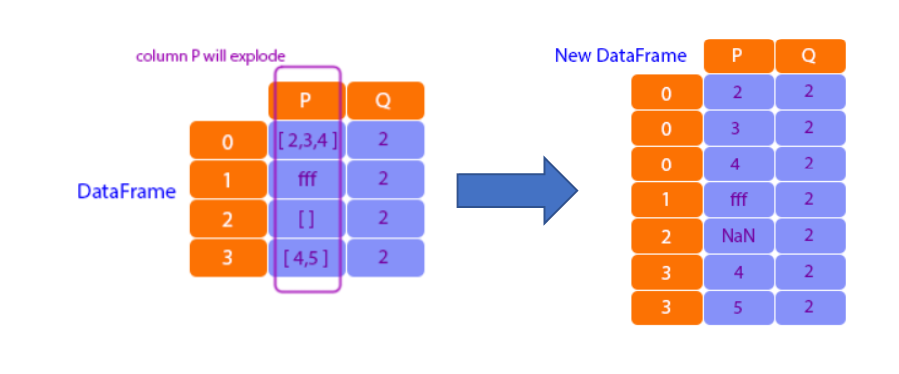

In [39]:
fr_cleaned = fr_cleaned.explode('cityAltLabel')
en_cleaned = en_cleaned.explode('cityAltLabel')
es_cleaned = es_cleaned.explode('cityAltLabel')
de_cleaned = de_cleaned.explode('cityAltLabel')

In [40]:
fr_cleaned.drop(columns='cityLabel', inplace=True)
en_cleaned.drop(columns='cityLabel', inplace=True)
es_cleaned.drop(columns='cityLabel', inplace=True)
de_cleaned.drop(columns='cityLabel', inplace=True)

### Translation

After that we can simply merge our files with the french and english ones to get the corresponding translation. It will create a repetition for files already in these languages but at least all files will have the same structure.

In [41]:
fr_cleaned = fr_cleaned.merge(raw_fr[['city', 'cityLabel']], how='left', on='city')
fr_cleaned.rename(columns={"cityLabel" : "labelFr"}, inplace = True)
fr_cleaned = fr_cleaned.merge(raw_en[['city', 'cityLabel']], how='left', on='city')
fr_cleaned.rename(columns={"cityLabel" : "labelEn"}, inplace = True)

en_cleaned = en_cleaned.merge(raw_fr[['city', 'cityLabel']], how='left', on='city')
en_cleaned.rename(columns={"cityLabel" : "labelFr"}, inplace = True)
en_cleaned = en_cleaned.merge(raw_en[['city', 'cityLabel']], how='left', on='city')
en_cleaned.rename(columns={"cityLabel" : "labelEn"}, inplace = True)

es_cleaned = es_cleaned.merge(raw_fr[['city', 'cityLabel']], how='left', on='city')
es_cleaned.rename(columns={"cityLabel" : "labelFr"}, inplace = True)
es_cleaned = es_cleaned.merge(raw_en[['city', 'cityLabel']], how='left', on='city')
es_cleaned.rename(columns={"cityLabel" : "labelEn"}, inplace = True)

de_cleaned = de_cleaned.merge(raw_fr[['city', 'cityLabel']], how='left', on='city')
de_cleaned.rename(columns={"cityLabel" : "labelFr"}, inplace = True)
de_cleaned = de_cleaned.merge(raw_en[['city', 'cityLabel']], how='left', on='city')
de_cleaned.rename(columns={"cityLabel" : "labelEn"}, inplace = True)

### Results
This is what the Dataset looks like after all the processing
We can then save the resulting files

In [44]:
fr_cleaned.head(20)

,city,cityAltLabel,population,countryLabel,coordinatesLabel,countryCode,labelFr,labelEn
0,Q3771,Gütersloh,100194,Allemagne,"8.383333333,51.9",DE,Gütersloh,Gütersloh
1,Q3674,Niamey,1026848,Niger,"2.111111111,13.508611111",NE,Niamey,Niamey
2,Q3141,Melbourne,4529500,Australie,"144.961388888,-37.820555555",AU,Melbourne,Melbourne
3,Q1963,Khartoum,5345000,Soudan,"32.52654,15.60308",SD,Khartoum,Khartoum
4,Q2256,Birmingham,1137100,Royaume-Uni,"-1.9025,52.48",GB,Birmingham,Birmingham
5,Q3659,Ndjamena,1092066,Tchad,"15.05,12.11",TD,N'Djaména,N'Djamena
6,Q3659,N'Djaména,1092066,Tchad,"15.05,12.11",TD,N'Djaména,N'Djamena
7,Q3805,Amman,4007526,Jordanie,"35.933333333,31.95",JO,Amman,Amman
8,Q3792,Lomé,837437,Togo,"1.222777777,6.131944444",TG,Lomé,Lomé
9,Q2471,Sanaa,2957000,Yémen,"44.2,15.35",YE,Sanaa,Sana'a


In [102]:
fr_cleaned.to_csv('final/csv/GrandesVillesFR.csv')
en_cleaned.to_csv('final/csv/GrandesVillesEN.csv')
es_cleaned.to_csv('final/csv/GrandesVillesES.csv')
de_cleaned.to_csv('final/csv/GrandesVillesDE.csv')

In [103]:
fr_cleaned.to_json('json/fr_cleaned.json', orient='records', lines='True')
en_cleaned.to_json('json/en_cleaned.json', orient='records', lines='True')
es_cleaned.to_json('json/es_cleaned.json', orient='records', lines='True')
de_cleaned.to_json('json/de_cleaned.json', orient='records', lines='True')

## Custom output structure

In that case, I was asked to output the data in another format than the usual csv. That's why I had to trandform the output format into a custom format.

In [104]:
my_file_fr = open("json/fr_cleaned.json")
content = my_file_fr.read()
content = content.replace('{', '').replace('}', '').replace(':', '=').replace(',', '~')
with open('final/GrandesVillesFR.txt', 'w') as f:
    f.write(content)

my_file_en = open("json/en_cleaned.json")
content = my_file_en.read()
content = content.replace('{', '').replace('}', '').replace(':', '=').replace(',', '~')
with open('final/GrandesVillesEN.txt', 'w') as f:
    f.write(content)

my_file_es = open("json/es_cleaned.json")
content = my_file_es.read()
content = content.replace('{', '').replace('}', '').replace(':', '=').replace(',', '~')
with open('final/GrandesVillesES.txt', 'w') as f:
    f.write(content)

my_file_de = open("json/de_cleaned.json")
content = my_file_de.read()
content = content.replace('{', '').replace('}', '').replace(':', '=').replace(',', '~')
with open('final/GrandesVillesDE.txt', 'w') as f:
    f.write(content)